# Double Deep Q-Network

---
This notebook has been prepared for Udacity's Deep Reinforcement Learning Nanodegree. Please take a look at the README file in the repo for details regarding setting up the environment.

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

Adjust the MAX_T_STEPS variable, and see some random actions taken by the untrained agent.

In [5]:
MAX_T_STEPS = 10
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
t_steps = 0

while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
    t_steps += 1
    if t_steps == MAX_T_STEPS:
        break
        
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training with DQN


Run the following cells to make the agent learn, using a Double DQN architecture.

In [6]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
import time
from dqn_agent import Agent

agent = Agent(37, 4, seed=42)

DEVICE:  cuda:0
Q network QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)
Learning rate: 0.0005
Tau: 0.001


In [7]:
BENCH_MARK_SCORE = 13

def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Main method to train the agent using DQN.
    """
    _start_time = time.time()
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            is_done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, is_done)
            state = next_state
            score += reward
            
            if is_done:
                break
                
        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay*eps)
        
        print('\rEpisode {}\tNext Eps: {}\tAverage Score: {:.2f}'.format(i_episode, eps, 
                                                                         np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tNext Eps:{}\tAverage Score: {:.2f}'.format(i_episode, eps, 
                                                                            np.mean(scores_window)))
        if np.mean(scores_window) >= BENCH_MARK_SCORE:
            _elapsed_min = (time.time() - _start_time) / 60.0
            print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, 
                                                                                         np.mean(scores_window)))
            print(f'Training time taken: {_elapsed_min} min')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores
    

Episode 100	Next Eps:0.6057704364907278	Average Score: 0.866
Episode 200	Next Eps:0.3669578217261671	Average Score: 5.1337
Episode 300	Next Eps:0.22229219984074702	Average Score: 7.944
Episode 400	Next Eps:0.1346580429260134	Average Score: 10.9775
Episode 478	Next Eps: 0.09108200798387568	Average Score: 13.08

Environment solved in 378 episodes!	Average Score: 13.08
Training time taken: 7.90057510137558 min


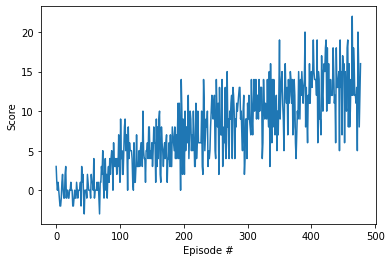

In [8]:
# Train the agent
scores = train(n_episodes=2000, max_t=1000, eps_end=0.05, eps_decay=0.995)

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [9]:
env.close()